Mount the drive, Define asset path and Setup dependencies

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change the working directory
path_to_folder = "fire_protection"
%cd /content/drive/My\ Drive/{path_to_folder}

#Importing the required libraries
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output


Mounted at /content/drive
/content/drive/My Drive/fire_protection


Read the original image and Generate the gray scale image


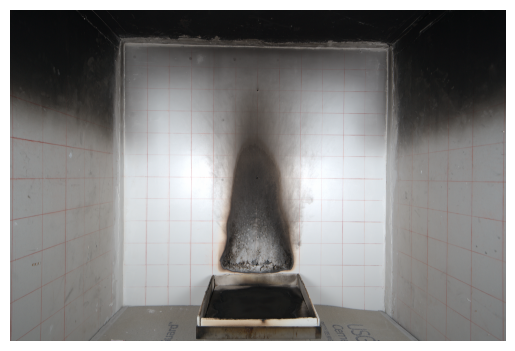

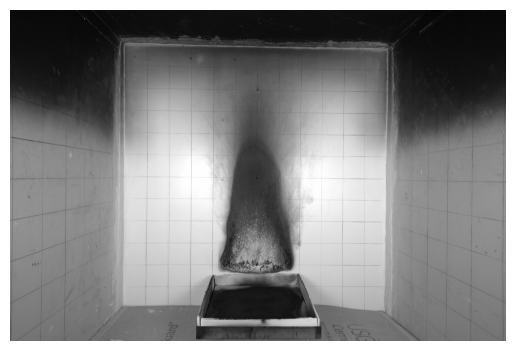

In [4]:
# Assuming you have an image file named 'image.jpg' in your folder
image_path = 'Glosstest1.tiff'  # Replace with your image file name

try:
  img = cv2.imread(image_path)
  if img is None:
    print(f"Error: Could not read image at path: {image_path}")
  else:
    # Convert BGR to RGB for matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# except FileNotFoundError:
#   print(f"Error: Image file not found at path: {image_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

# Convert to grayscale
grey_scale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display with cmap='gray' to ensure proper grayscale visualization
plt.imshow(grey_scale_image, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

Code for manually setting extreme/threshold points of smoke soot

Height of image (y-axis): 5320 pixels
Width of image (x-axis): 7968 pixels


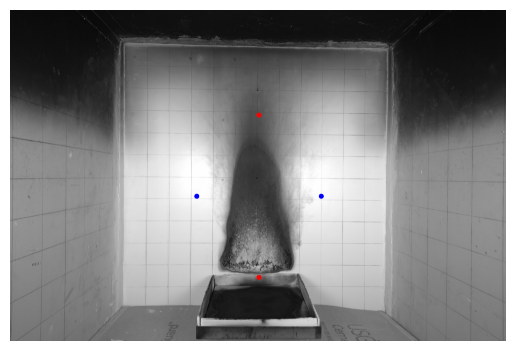

 
y_max_threshold: 4300
y_min_threshold: 1700
x_max_threshold: 5000
x_min_threshold: 3000


In [7]:
# Find the image dimension and plot points to select datum in the gary scaled image
height, width = grey_scale_image.shape  # for grayscale image
print(f"Height of image (y-axis): {height} pixels")
print(f"Width of image (x-axis): {width} pixels")

# Convert grayscale to color (3 channels)
gray_to_color_img = cv2.cvtColor(grey_scale_image, cv2.COLOR_GRAY2BGR)
img_with_point = gray_to_color_img.copy()

# Y_Point 1
y_point_coordinates1 = (4000, 1700)
color = (0, 0, 255)
radius = 40
thickness = -1
cv2.circle(img_with_point, y_point_coordinates1, radius, color, thickness)

# Y_Point 2
y_point_coordinates2 = (4000, 4300)
color = (0, 0, 255)
radius = 40
thickness = -1
cv2.circle(img_with_point, y_point_coordinates2, radius, color, thickness)
y_max_threshold = max(y_point_coordinates1[1], y_point_coordinates2[1])
y_min_threshold = min(y_point_coordinates1[1], y_point_coordinates2[1])


# X_Point 1
x_point_coordinates1 = (3000, 3000)
color = (255, 0, 0)
radius = 40
thickness = -1
cv2.circle(img_with_point, x_point_coordinates1, radius, color, thickness)

# X_Point 2
x_point_coordinates2 = (5000, 3000)
color = (255, 0, 0)
radius = 40
thickness = -1
cv2.circle(img_with_point, x_point_coordinates2, radius, color, thickness)

plt.imshow(cv2.cvtColor(img_with_point, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

x_max_threshold = max(x_point_coordinates1[0], x_point_coordinates2[0])
x_min_threshold = min(x_point_coordinates1[0], x_point_coordinates2[0])
print(" ")
print(f"y_max_threshold: {y_max_threshold}")
print(f"y_min_threshold: {y_min_threshold}")
print(f"x_max_threshold: {x_max_threshold}")
print(f"x_min_threshold: {x_min_threshold}")

Code for finding extreme y_cordinates of the smoke soot



First dark pixel (top to bottom) found at: (3962, 2113)
First dark pixel (bottom to top) found at: (4023, 4194)
 


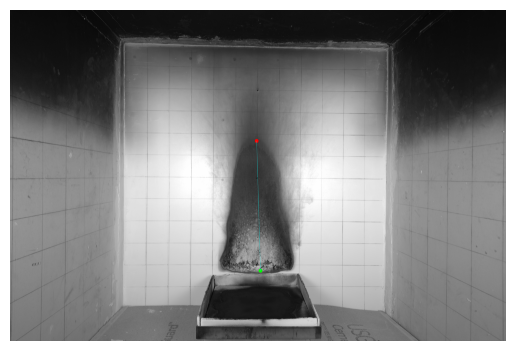

 
Soot height in pixels: 2081
Soot height in inches: 35.848406546080966


In [8]:
def find_dark_pixels(grey_image, x_min, x_max, y_min, y_max, intensity_threshold=50):
    # Ensure we're working with grayscale image

    # Initialize variables for storing results
    top_to_bottom_point = None
    bottom_to_top_point = None

    # Scan region within thresholds
    region = grey_image[y_min:y_max, x_min:x_max]

    # Scan top to bottom
    for y in range(region.shape[0]):
        for x in range(region.shape[1]):
            if region[y, x] <= intensity_threshold:
                top_to_bottom_point = (x + x_min, y + y_min)
                break
        if top_to_bottom_point is not None:
            break

    # Scan bottom to top
    for y in reversed(range(region.shape[0])):
        for x in range(region.shape[1]):
            if region[y, x] <= intensity_threshold:
                bottom_to_top_point = (x + x_min, y + y_min)
                break
        if bottom_to_top_point is not None:
            break

    return top_to_bottom_point, bottom_to_top_point

# Use the function
top_point, bottom_point = find_dark_pixels(
    grey_scale_image,
    x_min = x_min_threshold,
    x_max = x_max_threshold,
    y_min = y_min_threshold,
    y_max = y_max_threshold,
    intensity_threshold=50
)

# Visualize the results
img_with_points = cv2.cvtColor(grey_scale_image, cv2.COLOR_GRAY2BGR)

# Draw points if found
if top_point is not None:
    cv2.circle(img_with_points, top_point, 30, (0, 0, 255), -1)  # Red circle for top point
    print(f"First dark pixel (top to bottom) found at: {top_point}")
else:
    print("No dark pixel found from top to bottom")

if bottom_point is not None:
    cv2.circle(img_with_points, bottom_point, 30, (0, 255, 0), -1)  # Green circle for bottom point
    print(f"First dark pixel (bottom to top) found at: {bottom_point}")
else:
    print("No dark pixel found from bottom to top")

#Draw the line between two points
color = (255, 255, 0)  # Line color in BGR (Green)
thickness = 2        # Line thickness
cv2.line(img_with_points, top_point, bottom_point, color, thickness)

# Display the image with points
print(" ")
plt.imshow(cv2.cvtColor(img_with_points, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

soot_height = bottom_point[1] - top_point[1]
print(" ")
print(f"Soot height in pixels: {soot_height}")
soot_height_inches = soot_height / 58.05
print(f"Soot height in inches: {soot_height_inches}")

Croping the AOI, Applying Gausian blurr and thresholding the image

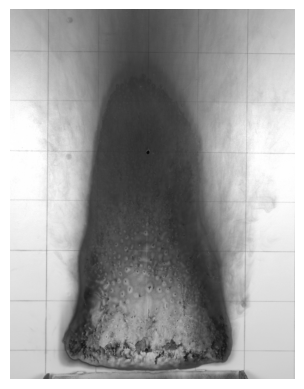

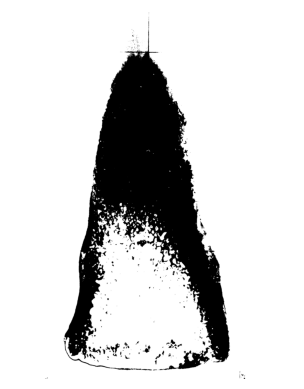

In [10]:
cropped_image = grey_scale_image[y_min_threshold:y_max_threshold, x_min_threshold:x_max_threshold]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(cropped_image, (5, 5), 0)

# Threshold value
intensity_threshold = 70

# Apply thresholding to the cropped image
thresholded_image = np.where(blurred_image > intensity_threshold, 255, 0).astype(np.uint8)

# Display the result
plt.imshow(cv2.cvtColor(thresholded_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Applying Morphology, Contors, Visualizing the edges and Plot the final output and the height magnitude

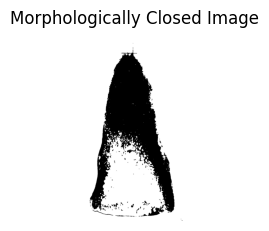

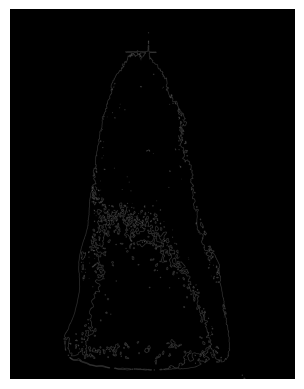


Soot height in pixels: 2081
Soot height in inches: 35.848406546080966



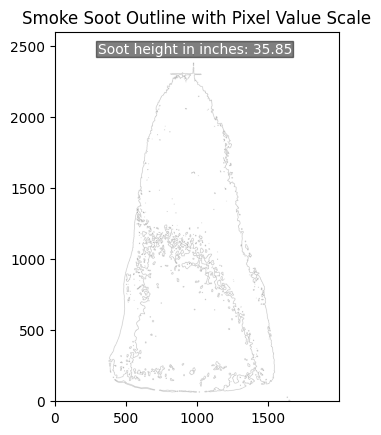

In [18]:
# Morphological operations (closing to fill small gaps)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

# Contour detection to extract the largest outline
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = np.zeros_like(cropped_image)
cv2.drawContours(contour_image, contours, -1, (255), 1)  # Draw contours

# Display the morphological results
plt.subplot(1, 3, 2)
plt.title("Morphologically Closed Image")
plt.imshow(closed_image, cmap='gray')
plt.axis('off')
plt.show()

# Perform edge detection using Canny
low_threshold = 50    # Minimum intensity gradient
high_threshold = 100  # Maximum intensity gradient
image_edges = cv2.Canny(closed_image, low_threshold, high_threshold)
plt.imshow(cv2.cvtColor(image_edges, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Set intensity of pixels below 30 to 255 and above 30 to 0
processed_image = np.where(image_edges < 30, 255, 0).astype(np.uint8)
flipped_image = cv2.flip(processed_image, 0)

print("")
print(f"Soot height in pixels: {soot_height}")
print(f"Soot height in inches: {soot_height_inches}")
print("")

# Display the processed image with the text annotation
plt.imshow(flipped_image, cmap='gray', origin='lower')  # Ensure the origin is at the bottom-left
plt.axis('on')
plt.title("Smoke Soot Outline with Pixel Value Scale")

# Add the soot height annotation to the plot
plt.text(
    x=300, y=2450,  # Coordinates for the text (adjust as needed)
    s=f"Soot height in inches: {soot_height_inches:.2f}",
    color="white",  # Text color
    fontsize=10,
    bbox=dict(facecolor='black', alpha=0.5, pad=1)  # Background box for better readability
)

plt.show()

